# UNIDAD 4 Métodos conexinistas

## Alumno: José Antonio García Casanova

# Introducción
 
Las redes neuronales son modelos que estan inspirados en el aprendizaje humano, forman parte de los modelos de aprendizaje no supervisados que crean una representación bidimensional (o tridimensional) de los datos, es decir, un conjunto de $n$ variables y $m$ registros pueden representarse como grupos bidimensionales facilitando la visualización y compresión de los datos. Entre los modelos de redes neuronales tenemos las redes competitivas, en estas redes, cada neurona se especializa en detectar un patrón, los Self-Organizing Map (SOM) forman parte de este tipo de redes (Berzal, F., 2018).

# Desarrollo
 
## Librerias 

Importamos las librerias necesarias para realizar el ejercicio:

In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from sklearn import preprocessing

# Conjuntos de datos
# ==============================================================================
from sklearn import datasets

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# KMeans
# ==============================================================================
from sklearn.cluster import KMeans

# Importamos librería para métricas
# ==============================================================================
from sklearn.metrics import classification_report

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## Conjuntos de datos seleccionados
 
Para el desarrollo de esta actividad seleccionamos el conjunto de datos de `iris` que se encuentra en la librería de sklearn:

In [2]:
iris = datasets.load_iris()

## Cálculo de los Valores Propios
 
Los valores propios son las varianzas de los componentes principales, para esto procedemos a estimar la matriz de covarianzas, esto lo haremos a través de la `np.cov`, después de obtener la matriz de covarianzas utilizamos el módulo `np.linal.eigh` para obtener los valores propios de la matriz:

In [3]:
X = iris.data

S= np.cov(X.T)

autovalores, autovectores = np.linalg.eigh(S)

print("Autovalores de la matriz: ", autovalores)
print()
print("Autovectores de la matriz: ")
print(autovectores)

Autovalores de la matriz:  [0.02383509 0.0782095  0.24267075 4.22824171]

Autovectores de la matriz: 
[[ 0.31548719  0.58202985  0.65658877 -0.36138659]
 [-0.3197231  -0.59791083  0.73016143  0.08452251]
 [-0.47983899 -0.07623608 -0.17337266 -0.85667061]
 [ 0.75365743 -0.54583143 -0.07548102 -0.3582892 ]]


Dividimos los dos primeros valores propios para obtener las dimensiones de nuestra red neuronal:

In [12]:
int(autovalores[3] / autovalores[2])

17

## Exportación del Dataframe

Exportamos nuestro conjunto de datos para hacer el entrenamiento de redes neuronales:

In [5]:
iris_df = pd.DataFrame(data= np.c_[iris['data'], iris['target']], columns= iris['feature_names'] + ['target'])

def rename(x):
    "This replace the float data type with a string data type"
    if x == 0.0:
        return 'setosa'
    elif x == 1.0:
        return 'versicolor'
    else:
        return 'virginica'

iris_df['target'] = iris_df['target'].apply(rename)

iris_df = iris_df[['target', 'sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']]

iris_df.to_csv('iris.csv', index=False)

## LabSOM

Cargamos nuetros datos en el programa **LabSOM**:

![imagen1](./Captura%20de%20pantalla%202022-10-30%20190508.png)

Como no desconocemos que distancia se adecua mejor a los datos, mantenemos la distancia euclidiana:

![imagen2](./Captura%20de%20pantalla%202022-10-30%20191808.png)

Como el cociente de los valores propios es ~17, entonces establecemos el tamaño de nuestra red como 170 de alto y 10 de ancho.

El resultado de los componentes es el siguiente:

![imagen3](./graph5.png)



Como se puede apreciar, se separan en 3 grupos. La anchura del sepalo es la variable más importante para poder distinguir a **setosa**, por su parte **virginica** se encuentra más acumulada en el largo del sepalo y la anchura y largo del pétalo y **versicolor** se encuentra disperson en el centro de los gráficos.

Aplicamos el método **SOM-Ward** para hacer la clusterización:

![imagen8](./clusters6.png)

Agruparlo en grupos de 3 es el resultado optimo, pues **setosa** se separa claramente del resto de las especies. La segmentación entre **virginica** y **versicolor** es un poco más difusa. En este conjunto de datos de iris sabemos que el número de especies son 3, por lo que la clusterización adecuada es en 3 clusters.

## Evaluación de Resultado de SOM:

Para evaluar los resultados, vamos a importarlos y unirlos con el dataset original, el join lo tendremos que hacer con las médidas ya que no existe un indice para unirlos:

In [13]:
results = pd.read_csv("./dataclusterlabels.txt", sep = ";", header = None)
results = results.rename(columns= {0:'target', 1:'sepal length (cm)', 2:'sepal width (cm)', 3:'petal length (cm)', 4:'petal width (cm)', 5:'resultados_SOM'})

In [7]:
evaluacion = iris_df.merge(results, 
             left_on=['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'], 
             right_on=['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'],
             suffixes = ('_original', '_redes'))

def to_number(x):
    if x == 'setosa':
        return 2
    elif x == 'virginica':
        return 3
    else:
        return 1

evaluacion['resultados_original'] = evaluacion['target_original'].apply(to_number)

evaluacion = evaluacion.drop_duplicates(keep = 'first')

print(classification_report(evaluacion.resultados_original, evaluacion.resultados_SOM))

              precision    recall  f1-score   support

           1       0.96      0.50      0.66        50
           2       0.94      1.00      0.97        50
           3       0.69      0.98      0.81        49

    accuracy                           0.83       149
   macro avg       0.86      0.83      0.81       149
weighted avg       0.86      0.83      0.81       149



Para este caso nuestro algortimo marca precisión macro del 86%, recall macro 83% y F1-score con un 81%.

## Comparativa de métodos de proyección y agrupación

### K-Means

Utilizaremos el algortimode **K-Means** para hacer las agrupaciones, para esto utilizaremos el método **Elbow** para determinar el número de clusters optimos. 

#### Elbow

Este método consiste en estimar la suma de los errores al cuadrado (SSE), la cúal es la distancia de todos los objetos con respecto de los centroides, y elegir el número de clusters dónde la diferencia haya sido mayor con respecto al número de clusters anterior, utilizaremos el método inertia_ para guardar el SSE:

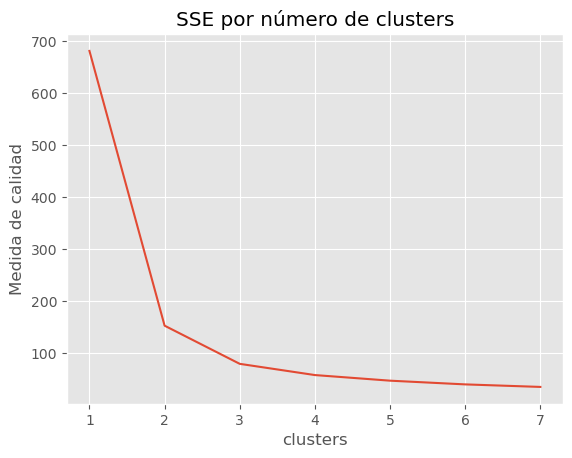

In [8]:
clusters = [x for x in range(1,8)]
sse_list = []

for cluster in clusters:
    modelo_kmeans = KMeans(n_clusters = cluster)
    modelo_kmeans.fit(X)
    sse_list.append(modelo_kmeans.inertia_)

fig, ax = plt.subplots(1, 1)
ax.set_xticks(clusters)
ax.set_title("SSE por número de clusters")
ax.set_xlabel('clusters')
ax.set_ylabel('Medida de calidad')
ax.plot(clusters, sse_list)

De acuerdo al criterio de selección **Elbow**, el número de clusters seleccionado es 3.

#### Modelo K-Means 

Una vez seleccionado el número de clusters optimos, implementamos el modelo K-Means:

Text(0.5, 1.0, 'Clusters = 3')

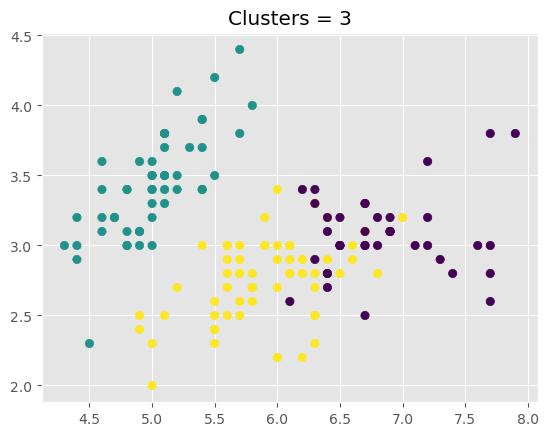

In [9]:
fig, ax = plt.subplots(1, 1)

model_kmeans = KMeans(n_clusters = 3)
y_hat = model_kmeans.fit_predict(X = X)
ax.scatter(x = X[:, 0],
           y = X[:, 1], 
           c = y_hat)

ax.set_title('Clusters = 3')

Evaluamos el desempeño de nuesto modelo:

In [10]:
y_hat_fix = []

for i in y_hat:
    if i == 1:
        y_hat_fix.append(0)
    elif i == 0:
        y_hat_fix.append(1)
    else:
        y_hat_fix.append(i)

y_hat_fix = np.array(y_hat_fix)

In [11]:
print(classification_report(iris.target, np.array(y_hat_fix)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.05      0.04      0.05        50
           2       0.23      0.28      0.25        50

    accuracy                           0.44       150
   macro avg       0.43      0.44      0.43       150
weighted avg       0.43      0.44      0.43       150



Para este caso nuestro algortimo marca precisión macro del 91%, recall macro y F1-score ambos con un 89%.

# Conclusiones

Como se observó, el método de redes neuronales SOM hace una agrupación bastante confiable aunque al compararlo con el método de K-Means este último presenta mejores resultados, la diferencia no es mucha, pero existe. La ventaja de hacerlo a través de redes neuronales, es que este método permite observar los gráficos de componentes y observar hacia dónde se van orientando cada uno de los grupos, este tipo de análisis permite anticiparse a la selección de los clusters y justificar la selección de los mismos. 

# Referencias 

Berzal, F. (2018). Redes Neuronales & Deep Learning (Spanish Edition). Independently published.